In [4]:
import argparse
import glob
from pathlib import Path
import pickle
import pandas as pd
import string

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib.patches import Patch, Rectangle
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors

from mist.utils.plot_utils import *

from typing import List

In [5]:
plt.style.use(['seaborn-white', 'seaborn-paper'])
plt.rc('font', family='sans serif')
# sns.set_palette(['#9e0059', '#6da7de', '#ee266d', '#dee000', '#eb861e'])
sns.set_context('paper', font_scale=1.3)

width = 7
height = width / 1.618

In [6]:
def plot_retrieval_accuracy(retrieval_files, model_names, dist_names, models_to_plot, save_name):
    save_dir = Path(save_name).parent
    save_dir.mkdir(exist_ok=True)

    assert len(retrieval_files) == len(dist_names)

    # Extract rankings from file
    ret_names, ret_inds = [], []
    for i in retrieval_files:
        with open(i, "rb") as fp:
            a = pickle.load(fp)
            ind_found, names = np.array(a["ind_found"]), np.array(a["names"])
            sort_order = np.argsort(names)
            names = names[sort_order]
            ind_found = ind_found[sort_order]

            ret_names.append(names)
            ret_inds.append(ind_found)

    # Calc common inds and subset
    common_inds = None
    for i, j in zip(ret_names, ret_inds):
        i = i[~np.isnan(j.astype(float))]
        temp_names = set(i)
        if common_inds is None:
            common_inds = temp_names
        else:
            common_inds = common_inds.intersection(temp_names)

    # Re-mask each based upon common inds
    new_names, new_inds = [], []
    for ret_name, ret_ind in zip(ret_names, ret_inds):
        mask = [i in common_inds for i in ret_name]
        new_names.append(ret_name[mask])
        new_inds.append(ret_ind[mask])
    ret_inds = new_inds
    ret_names = new_names

    # Create top k
    k_vals = np.arange(0, 1001)
    # max_k = np.max(k_vals) + 1
    top_k_x, top_k_y = [], []
    for ret_ind in ret_inds:
        new_x, new_y = [], []
        for k in k_vals:
            new_x.append(k)
            new_y.append(np.mean(ret_ind <= k))
        top_k_x.append(new_x), top_k_y.append(new_y)
    top_k_x, top_k_y = np.array(top_k_x), np.array(top_k_y)

    # Plot
    cmap = plt.cm.get_cmap("tab10")
    num_colors = cmap.N
    model_colors = {"MIST public": mcolors.to_hex(cmap(0)),
                    "MIST retrain": mcolors.to_hex(cmap(1/num_colors)),
                    "MIST full": mcolors.to_hex(cmap(2/num_colors)),
                    "CSI:FingerID": mcolors.to_hex(cmap(3/num_colors)),}
    dist_styles = {
        "Cosine": ":",
        "Bayes": "--",
        "Contrastive": "-",
    }

    fig, axes = plt.subplots(1, len(models_to_plot), figsize=(width * 2.2, height))

    for i, ((m_idx, lim), ax) in enumerate(zip(models_to_plot, axes)):
        for x, y, model, dist in zip(top_k_x[m_idx], top_k_y[m_idx], model_names[m_idx], dist_names[m_idx]):
            color, style = model_colors[model], dist_styles[dist]
            ax.step(x[0:], y[0:], c=color, linestyle=style, label=f"{model} - {dist}")
        ax.set_box_aspect(1)
        ax.set_xlim([0, lim])
        ax.set_ylim([0, 1])
        ax.set_xlabel("Top k")

        ax.text(-0.1, 1.1, string.ascii_lowercase[i], transform=ax.transAxes, size=15, weight='bold')

    axes[0].set_ylabel("Accuracy")

    # Build legend
    patch_legend_handles = [
        Patch(facecolor=model_colors[model], label=model) for model in set(model_names)
    ]
    patch_legend_handles.append(
        Rectangle((0, 0), 1, 1, fill=False, edgecolor="none", visible=False)
    )

    patch_legend_handles.insert(
        0,
        Rectangle(
            (0, 0), 1, 1, fill=False, edgecolor="none", visible=False, label="Model"
        ),
    )
    line_legend_handles = [
        Line2D(
            [0, 1],
            [0, 1],
            linestyle=dist_styles[dist],
            linewidth=0.8,
            color="black",
            label=dist,
        )
        for dist in set(dist_names)
    ]
    line_legend_handles.insert(
        0,
        Rectangle(
            (0, 0), 1, 1, fill=False, edgecolor="none", visible=False, label="Distance"
        ),
    )
    legend_handles = [*patch_legend_handles, *line_legend_handles]

    legend = ax.legend(
        handles=legend_handles,
        loc="lower right",  # (0.1,0.0),
        frameon=False,
        facecolor="none",
        fancybox=False,  # ncol=2,
        columnspacing=0.5,
    )
    
    # set_size(*ax_figsize)
    fig.savefig(save_name, format="pdf", bbox_inches="tight", dpi=400, transparent=True)

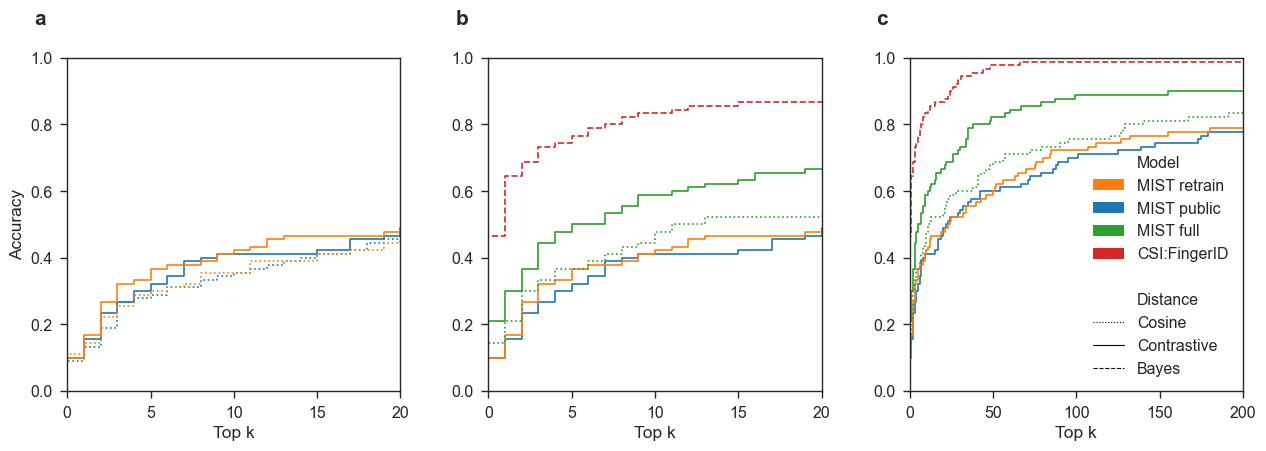

In [28]:
retrieval_files = [
    "../../pretrained_models/mist_canopus_public/fp_model/retrieval_casmi2022/out_retrieval_single/retrieval_fp_intpubchem_with_morgan4096_retrieval_db_casmi2022_cosine_0_ind_found.p",
    "../../pretrained_models/mist_canopus_public/contrastive_model/retrieval_casmi2022/merged_retrieval_single/retrieval_avged_0_3_ind_found.p",
    "../../results/retrained_models/mist_fp_model_aug/retrieval_casmi2022/out_retrieval_single/retrieval_fp_intpubchem_with_morgan4096_retrieval_db_casmi2022_cosine_0_ind_found.p",
    "../../results/retrained_models/contrast_model_aug/retrieval_casmi2022/merged_retrieval_single/retrieval_avged_0_3_ind_found.p",
    "../../pretrained_models/mist_full/fp_model/retrieval_casmi2022/out_retrieval_single/retrieval_fp_intpubchem_with_morgan4096_retrieval_db_casmi2022_cosine_0_ind_found.p",
    "../../pretrained_models/mist_full/contrastive_model/retrieval_casmi2022/merged_retrieval_single/retrieval_avged_0_3_ind_found.p",
    "../../data/paired_spectra/casmi2022/prev_results/csi_ind_found.p"
]
save_name = "../../results/reusability/retrieval_lineplots/top_k_retrieval_casmi2022.pdf"

model_names = np.array(["MIST public", "MIST public", "MIST retrain", "MIST retrain", "MIST full", "MIST full", "CSI:FingerID", ])
dist_names = np.array(["Cosine", "Contrastive", "Cosine", "Contrastive", "Cosine", "Contrastive", "Bayes"])
# tuples of (model indices, k limit)
models_to_plot = [([0, 1, 2, 3], 20), ([1, 3, 4, 5, 6], 20), ([1, 3, 4, 5, 6], 200)]

plot_retrieval_accuracy(retrieval_files, model_names, dist_names, models_to_plot, save_name)

In [83]:
def top_k_retrieval(retrieval_files: List[str], max_k=200):
    # Extract rankings from file
    ret_names, ret_inds = [], []
    for i in retrieval_files:
        with open(i, "rb") as fp:
            a = pickle.load(fp)
            ind_found, names = np.array(a["ind_found"]), np.array(a["names"])
            sort_order = np.argsort(names)
            names = names[sort_order]
            ind_found = ind_found[sort_order]

            ret_names.append(names)
            ret_inds.append(ind_found)

    # Calc common inds and subset
    common_inds = None
    for i, j in zip(ret_names, ret_inds):
        i = i[~np.isnan(j.astype(float))]
        temp_names = set(i)
        if common_inds is None:
            common_inds = temp_names
        else:
            common_inds = common_inds.intersection(temp_names)

    # Re-mask each based upon common inds
    new_names, new_inds = [], []
    for ret_name, ret_ind in zip(ret_names, ret_inds):
        mask = [i in common_inds for i in ret_name]
        new_names.append(ret_name[mask])
        new_inds.append(ret_ind[mask])
    ret_inds = new_inds
    ret_names = new_names

    # Create top k
    k_vals = np.arange(0, 1001)
    # max_k = np.max(k_vals) + 1
    top_k_x, top_k_y = [], []
    for ret_ind in ret_inds:
        new_x, new_y = [], []
        for k in k_vals:
            new_x.append(k)
            new_y.append(np.mean(ret_ind <= k))
        top_k_x.append(new_x), top_k_y.append(new_y)
    top_k_x, top_k_y = np.array(top_k_x), np.array(top_k_y)

    return (top_k_x, top_k_y)

In [86]:
def top_k_ablation(retrieval_files: List[str], max_k=200):
    
    # Extract rankings from file
    ret_results = {}
    for file in retrieval_files:
        with open(file, "rb") as fp:
            a = pickle.load(fp)
            ind_found, names = np.array(a["ind_found"]), np.array(a["names"])
            sort_order = np.argsort(names)
            names = names[sort_order]
            ind_found = ind_found[sort_order]

            seed = file.split("/")[4].replace("ablation_retrieval", "")
            model = file.split("/")[5].replace("contrast_", "")
            ret_results[(model, seed)] = (names, ind_found)
    print(len(ret_results))

    # Calc common inds and subset
    common_inds = None
    for i, j in ret_results.values():
        i = i[~np.isnan(j.astype(float))]
        temp_names = set(i)
        if common_inds is None:
            common_inds = temp_names
        else:
            common_inds = common_inds.intersection(temp_names)

    # Re-mask each based upon common inds
    results_masked = {}
    for key, (ret_name, ret_ind) in ret_results.items():
        mask = [i in common_inds for i in ret_name]
        results_masked[key] = (ret_name[mask], ret_ind[mask])
    ret_results = results_masked

    # Create top k
    top_k_results = {}
    k_vals = np.arange(0, max_k)
    # max_k = np.max(k_vals) + 1
    for key, (ret_name, ret_ind) in ret_results.items():
        top_k_x, top_k_y = [], []
        for k in k_vals:
            top_k_x.append(k)
            top_k_y.append(np.mean(ret_ind <= k))
        top_k_results[key] = (np.array(top_k_x), np.array(top_k_y))

    return top_k_results


In [87]:
ablation_files = glob.glob('../../results/ablation/ablation_retrieval*/**/merged_retrieval/*ind_found.p')

# boxplot at k=5 and k=20
k_values = [5, 20]
top_k_ablation = top_k_ablation(ablation_files, max_k=20)
print(len(list(top_k_ablation.values())))
ablation_models = list(set([i[0] for i in list(top_k_ablation.keys())]))
top_k_values = {}
for model in ablation_models:
    for key, (x, y) in top_k_ablation.items():
        if key[0] == model:
            for k in k_values:
                if (model, k) not in top_k_values:
                    top_k_values[(model, k)] = [y[k-1]]
                else:
                    top_k_values[(model, k)].append(y[k-1])

for k, v in top_k_values.items():
    print(k, np.mean(v), np.std(v))

25
25
('magma', 5) 0.22857142857142856 0.01969149821727174
('magma', 20) 0.43285714285714283 0.024989793835051295
('simulated', 5) 0.24857142857142858 0.028356333201827445
('simulated', 20) 0.4385714285714286 0.026954231805875997
('pairwise', 5) 0.21428571428571427 0.0101015254455221
('pairwise', 20) 0.4428571428571429 0.012777531299998797
('unfolding', 5) 0.2257142857142857 0.03149343955006943
('unfolding', 20) 0.44428571428571423 0.013850513878332376
('full', 5) 0.2457142857142857 0.018405855323893036
('full', 20) 0.45285714285714285 0.01840585532389305


Top-1 retrieval accuracy for MIST public - Cosine: 0.08888888888888889
Top-1 retrieval accuracy for MIST public - Contrastive: 0.1
Top-1 retrieval accuracy for MIST retrain - Cosine: 0.1111111111111111
Top-1 retrieval accuracy for MIST retrain - Contrastive: 0.1
Top-1 retrieval accuracy for MIST public - Contrastive: 0.1
Top-1 retrieval accuracy for MIST retrain - Contrastive: 0.1
Top-1 retrieval accuracy for MIST full - Cosine: 0.14444444444444443
Top-1 retrieval accuracy for MIST full - Contrastive: 0.2111111111111111
Top-1 retrieval accuracy for CSI:FingerID - Bayes: 0.4666666666666667
Top-1 retrieval accuracy for MIST public - Contrastive: 0.1
Top-1 retrieval accuracy for MIST retrain - Contrastive: 0.1
Top-1 retrieval accuracy for MIST full - Cosine: 0.14444444444444443
Top-1 retrieval accuracy for MIST full - Contrastive: 0.2111111111111111
Top-1 retrieval accuracy for CSI:FingerID - Bayes: 0.4666666666666667


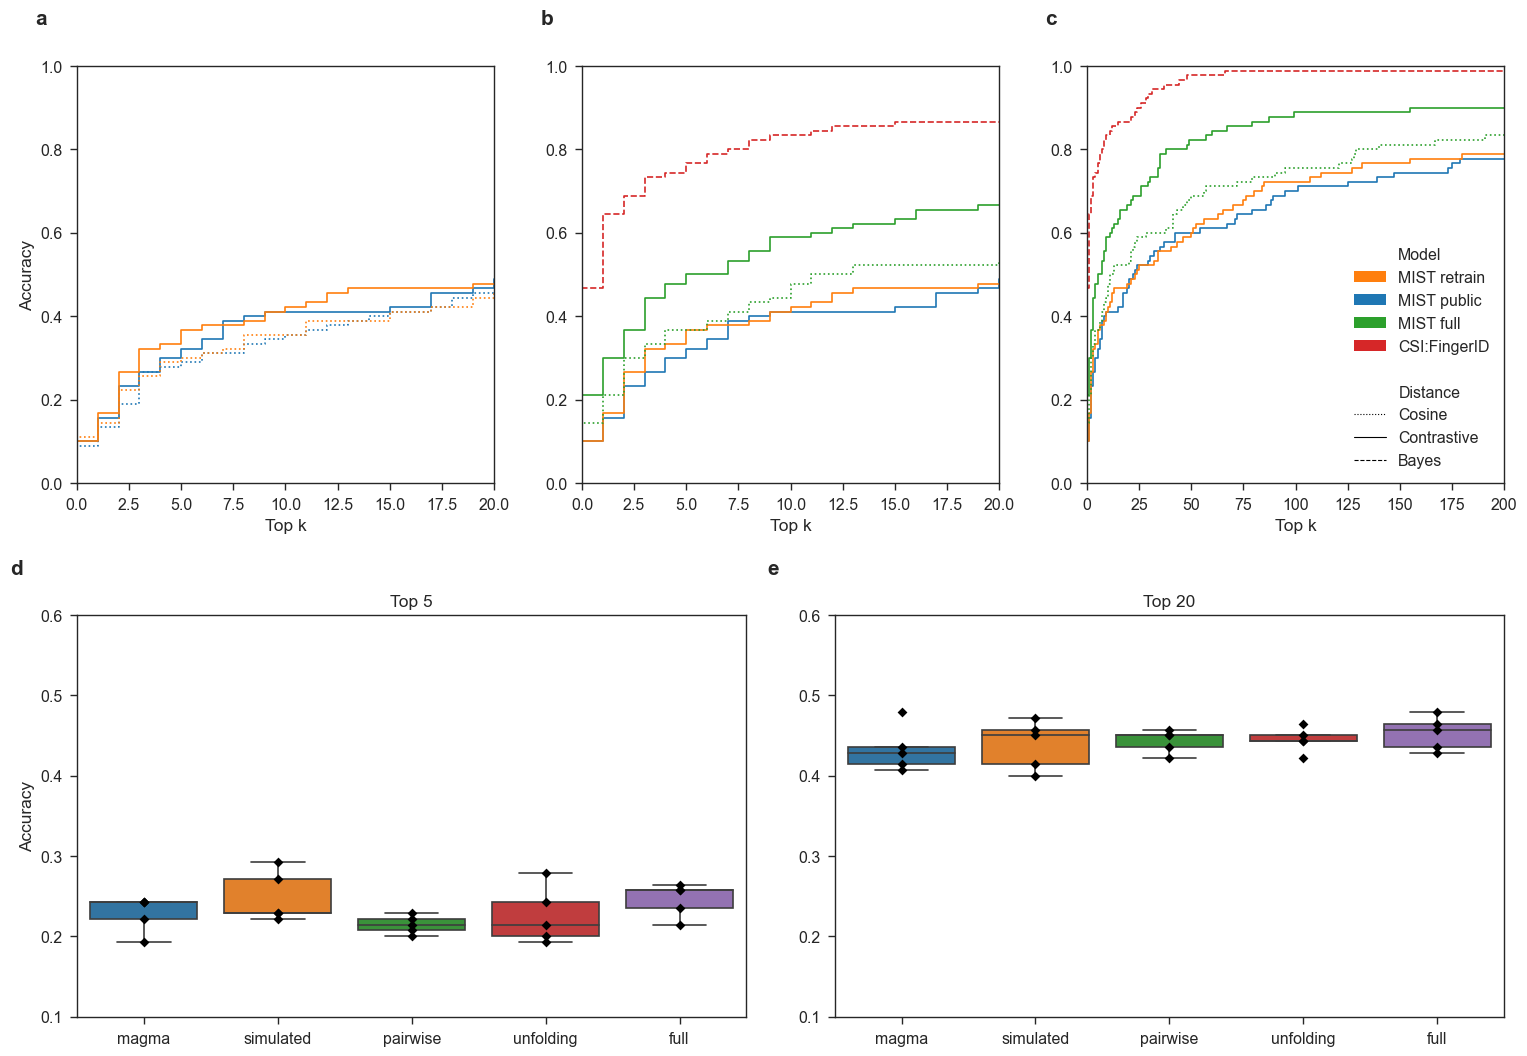

In [91]:
fig, axes = plt.subplot_mosaic("AABBCC;DDDEEE", figsize=(width * 2.2, height * 2.5))
fig.tight_layout(h_pad=7)
step_axes = [axes["A"], axes["B"], axes["C"]]
box_axes = [axes["D"], axes["E"]]

# step plots
cmap = plt.cm.get_cmap("tab10")
num_colors = cmap.N
model_colors = {"MIST public": mcolors.to_hex(cmap(0)),
                "MIST retrain": mcolors.to_hex(cmap(1/num_colors)),
                "MIST full": mcolors.to_hex(cmap(2/num_colors)),
                "CSI:FingerID": mcolors.to_hex(cmap(3/num_colors)),}
dist_styles = {
    "Cosine": ":",
    "Bayes": "--",
    "Contrastive": "-",
}

top_k_x, top_k_y = top_k_retrieval(retrieval_files, max_k=200)

for i, ((m_idx, lim), ax) in enumerate(zip(models_to_plot, step_axes)):
    for x, y, model, dist in zip(top_k_x[m_idx], top_k_y[m_idx], model_names[m_idx], dist_names[m_idx]):
        color, style = model_colors[model], dist_styles[dist]
        ax.step(x[0:], y[0:], c=color, linestyle=style, label=f"{model} - {dist}")

        print(f"Top-1 retrieval accuracy for {model} - {dist}: {y[1]}")

    ax.set_box_aspect(1)
    ax.set_xlim([0, lim])
    ax.set_ylim([0, 1])
    ax.set_xlabel("Top k")

    ax.text(-0.1, 1.1, string.ascii_lowercase[i], transform=ax.transAxes, size=15, weight='bold')

step_axes[0].set_ylabel("Accuracy")

# Build legend
patch_legend_handles = [
    Patch(facecolor=model_colors[model], label=model) for model in set(model_names)
]
patch_legend_handles.append(
    Rectangle((0, 0), 1, 1, fill=False, edgecolor="none", visible=False)
)

patch_legend_handles.insert(
    0,
    Rectangle(
        (0, 0), 1, 1, fill=False, edgecolor="none", visible=False, label="Model"
    ),
)
line_legend_handles = [
    Line2D(
        [0, 1],
        [0, 1],
        linestyle=dist_styles[dist],
        linewidth=0.8,
        color="black",
        label=dist,
    )
    for dist in set(dist_names)
]
line_legend_handles.insert(
    0,
    Rectangle(
        (0, 0), 1, 1, fill=False, edgecolor="none", visible=False, label="Distance"
    ),
)
legend_handles = [*patch_legend_handles, *line_legend_handles]

legend = ax.legend(
    handles=legend_handles,
    loc="lower right",  # (0.1,0.0),
    frameon=False,
    facecolor="none",
    fancybox=False,  # ncol=2,
    columnspacing=0.5,
)

# box plots
for i, k in enumerate(k_values):
    plot_data = {key[0]: value for key, value in top_k_values.items() if key[1] == k}
    plot_df = pd.DataFrame(plot_data)
    plot_df = plot_df.melt(var_name='model', value_name='accuracy')
    
    sns.boxplot(data=plot_df, x='model', y='accuracy', ax=box_axes[i], showfliers=False)
    sns.stripplot(data=plot_df, x="model", y="accuracy", ax=box_axes[i], jitter=False, color="black", marker="D")
    
    box_axes[i].set_box_aspect(0.6)
    box_axes[i].set_title(f"Top {k}")
    box_axes[i].set_xlabel("")
    box_axes[i].set_ylabel("")
    box_axes[i].set_ylim(0.1, 0.6)

    box_axes[i].text(-0.1, 1.1, string.ascii_lowercase[i+3], transform=box_axes[i].transAxes, size=15, weight='bold')

box_axes[0].set_ylabel("Accuracy")

fig.tight_layout()

save_name = "../../results/reusability/ablation_retrieval.pdf"
plt.savefig(save_name, format="pdf", bbox_inches="tight", dpi=600, transparent=True)